<h2> Imports </h2>

In [1]:
from ngboost import NGBRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from ngboost.distns import Exponential, Normal
from scipy.stats import burr
from ngboost.scores import LogScore, CRPScore
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
import math
from scipy import stats
from scipy.spatial import distance
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import warnings
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, RFE
from sklearn.metrics.cluster import normalized_mutual_info_score
warnings.filterwarnings("ignore")

<h2> Helper Methods </h2>

In [2]:
## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

    
def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio


#calculates all error metrics needed
def calculate_errors(y_test, y_pred, nb_columns):
    n = len(y_test)
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test, y_pred)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    pearson_corr, _ = pearsonr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    spearman_corr, _ = spearmanr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    distance_corr = distance.correlation(np.array(y_test).ravel(), np.array(y_pred).ravel())
    acc = 100 - mape_score
    nmi = normalized_mutual_info_score(np.array(y_test).ravel(), np.array(y_pred).ravel())
    aic = n * np.log(mse_score)
    bic = n * np.log(mse_score)
    print('\nRegression Error Metrics')
    print('R2: %.5f' % r2_Score)
    print('Adj-R2: %.5f' % adjusted_r2)
    print('RMSE: %.5f' % rmse_score)
    print('MSE: %.5f' % mse_score)
    print('MAE: %.5f' % mae_score)
    print('MAPE: %.5f' % mape_score)
    print('Accuracy: %.5f' % acc)
    print('\nCorrelations')
    print('Pearson: %.5f' % pearson_corr)
    print('Spearman: %.5f' % spearman_corr)
    print('Distance: %.5f' % distance_corr)
    
    print('\nExtra')
    print('NMI: %.5f' % nmi)
    print('AIC: %.5f' % aic)
    print('BIC: %.5f' % bic)
    
    
def gen_xspan(mean, std, n=2, num=100):
#Generate span for x axis to plot the probabilty distribution
    return np.linspace(mean - n * std, mean + n * std, num)

def normalize_ticks(ax):
    cln_ticks = lambda t: float(t.replace("−", "-"))
    get_ticks = lambda ax: list(
        map(cln_ticks, [item.get_text() for item in ax.get_yticklabels()])
    )
    labels = get_ticks(ax)
    labels = [f"{l / np.max(labels):.3f}" for l in labels]
    ax.set_yticklabels(labels)
    return ax

def heavyside(thresholds, actual):
    # Given a deterministic observation, make a CDF out of it
    result = [1 if t >= actual else 0 for t in thresholds]
    return result

def is_cdf_valid(case):
    if case[0] < 0 or case[0] > 1:
        return False
    for i in xrange(1, len(case)):
        if case[i] > 1 or case[i] < case[i-1]:
            return False
    return True

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=i)
        model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv)
    return scores

def calc_crps(thresholds, predictions, actuals):
    nthresh = len(thresholds)  # 70 in example
    ncases  = len(predictions)
    crps = 0
    for case, actual in zip(predictions, actuals):
        if (len(case) == nthresh) and is_cdf_valid(case):
            obscdf = heavyside(thresholds, actual)
            for fprob, oprob in zip(case, obscdf):
                crps = crps + (fprob - oprob)*(fprob - oprob)
        else:
            crps = crps + nthresh  # treat delta at each threshold as 1
    crps = crps / float(ncases * nthresh)

<h2> Read Data</h2>

In [3]:
input_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')
output_column ='LE_bowen_corr_mm'
df.head()

Date    Site  Year  Month  Day Climate Vegetation  Latitude  \
0   3/8/2000  FI-Jok  2000      3    8   Other        CRO   60.8986   
1   3/9/2000  FI-Jok  2000      3    9   Other        CRO   60.8986   
2  3/11/2000  FI-Jok  2000      3   11   Other        CRO   60.8986   
3  3/12/2000  FI-Jok  2000      3   12   Other        CRO   60.8986   
4  3/15/2000  FI-Jok  2000      3   15   Other        CRO   60.8986   

   Longitude  Site_1  ...  Eeflux_NDVI-2  Eeflux_NDVI-3  Eeflux_NDVI-4  \
0   23.51345       1  ...            NaN            NaN            NaN   
1   23.51345       1  ...            NaN            NaN            NaN   
2   23.51345       1  ...          0.003            NaN            NaN   
3   23.51345       1  ...         -0.034          0.003            NaN   
4   23.51345       1  ...         -0.025         -0.034          0.003   

   Eeflux_NDVI-5  Eeflux_Albedo  Eeflux_Albedo-1  Eeflux_Albedo-2  \
0            NaN          0.581              NaN              NaN   
1            NaN          0.559            0.581              NaN   
2            NaN          0.557            0.559            0.581   
3            NaN          0.555            0.557            0.559   
4            NaN          0.540            0.555            0.557   

   Eeflux_Albedo-3  Eeflux_Albedo-4  Eeflux_Albedo-5  
0              NaN              NaN              NaN  
1              NaN              NaN              NaN  
2              NaN              NaN              NaN  
3            0.581              NaN              NaN  
4            0.559            0.581              NaN  

[5 rows x 122 columns]

<h2> Drop Columns </h2>

In [4]:
columnsToDrop = ['Date','Year','Month','Day','Latitude','Longitude',
                'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'ET_bowen_corr_mm', 'ETo', 'Climate'
                ]    

<h2> Data Preprocessing </h2>

In [5]:
#drop na
df.dropna(inplace=True)

#set output variable between 1 and 15 only
df = df[df[output_column].between(1, 15)]

#drop desired columns, rename, and drop the nans
df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

#generate lags for columns
lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
df = generate_lags(df, lagsForColumns)

#drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)
print("checking null values in the whole dataset")
print(df.isnull().values.any())
print(df.columns)
#df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
#df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
df.dropna(inplace=True)


(5123, 51)
checking null values in the whole dataset
False
Index(['Site', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm', 'Eeflux_LST',
       'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3', 'Eeflux_LST-4',
       'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1', 'Eeflux_NDVI-2',
       'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5', 'Eeflux_Albedo',
       'Eeflux_Albedo-1', 'Eeflux_Albedo-2', 'Eeflux_Albedo-3',
       'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')


In [6]:
print(np.array(df['LE_bowen_corr_mm']).mean())

3.8792617744331452


<h2> Split Data </h2>

In [7]:
#split into train and test according to special split
X_train, X_test, Y_train, Y_test = split_train_test_valid(df, 0.8, 0.2)

X_train = X_train.drop('Site', axis = 1)
X_test = X_test.drop('Site', axis = 1)
columns = X_train.columns
X_train.columns

Number of sites: 24


Index(['Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5', 'Site_6', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Vegetation_1', 'Vegetation_2',
       'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5', 'RH',
       'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1', 'TA-2', 'TA-3',
       'TA-4', 'TA-5', 'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2',
       'Eeflux_LST-3', 'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI',
       'Eeflux_NDVI-1', 'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4',
       'Eeflux_NDVI-5', 'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5'],
      dtype='object')

# RFE

In [8]:
# create pipeline
rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=38)
model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
n_scores = cross_val_score(pipeline, X_train, Y_train, scoring='r2', cv=cv)

In [25]:
# report performance
print('R2: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

R2: 0.572 (0.021)


## RFE Tuning

In [11]:
num_features = np.arange(30,49,1)
results, names = list(), list()
for num in num_features:
    print(str(num) + " features")
    # create pipeline
    rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=num)
    model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)
    n_scores = cross_val_score(pipeline, X_train, Y_train, scoring='r2', cv=cv)
    results.append(n_scores)
    names.append(num)
    print('R2: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

30 features
R2: 0.573 (0.023)
31 features
R2: 0.571 (0.021)
32 features
R2: 0.568 (0.017)
33 features
R2: 0.567 (0.016)
34 features
R2: 0.572 (0.018)
35 features
R2: 0.572 (0.026)
36 features
R2: 0.573 (0.026)
37 features
R2: 0.569 (0.020)
38 features
R2: 0.575 (0.018)
39 features
R2: 0.568 (0.018)
40 features
R2: 0.568 (0.025)
41 features
R2: 0.575 (0.019)
42 features
R2: 0.574 (0.020)
43 features
R2: 0.581 (0.016)
44 features
R2: 0.567 (0.009)
45 features
R2: 0.574 (0.017)
46 features
R2: 0.571 (0.018)
47 features
R2: 0.571 (0.015)
48 features
R2: 0.573 (0.022)


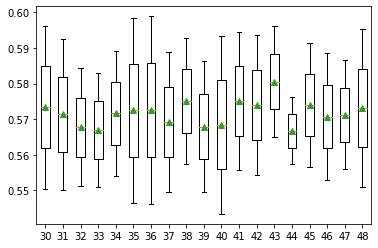

In [12]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Which features are actually selected

In [14]:
# define RFE
rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=num)
# fit RFE
rfe.fit(X_train, Y_train)
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=True, Rank: 1
Column: 1, Selected=True, Rank: 1
Column: 2, Selected=True, Rank: 1
Column: 3, Selected=True, Rank: 1
Column: 4, Selected=True, Rank: 1
Column: 5, Selected=True, Rank: 1
Column: 6, Selected=True, Rank: 1
Column: 7, Selected=True, Rank: 1
Column: 8, Selected=True, Rank: 1
Column: 9, Selected=True, Rank: 1
Column: 10, Selected=True, Rank: 1
Column: 11, Selected=False, Rank: 2
Column: 12, Selected=True, Rank: 1
Column: 13, Selected=True, Rank: 1
Column: 14, Selected=True, Rank: 1
Column: 15, Selected=True, Rank: 1
Column: 16, Selected=True, Rank: 1
Column: 17, Selected=True, Rank: 1
Column: 18, Selected=True, Rank: 1
Column: 19, Selected=True, Rank: 1
Column: 20, Selected=True, Rank: 1
Column: 21, Selected=True, Rank: 1
Column: 22, Selected=True, Rank: 1
Column: 23, Selected=True, Rank: 1
Column: 24, Selected=True, Rank: 1
Column: 25, Selected=True, Rank: 1
Column: 26, Selected=True, Rank: 1
Column: 27, Selected=True, Rank: 1
Column: 28, Selected=True, Ra